In [1]:
import numpy as np
from numpy.random import randint,rand

import pandas as pd
import os
import scipy as sp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from numba import vectorize, float64, boolean, njit


import tensorflow as tf
# try:
#     # Disable all GPUS
#     tf.config.set_visible_devices([], 'GPU')
#     visible_devices = tf.config.get_visible_devices()
#     for device in visible_devices:
#         assert device.device_type != 'GPU'
# except:
#     # Invalid device or cannot modify virtual devices once initialized.
#     pass


# tf.config.experimental.set_lms_enabled(True)
from tensorflow.keras.utils import Sequence
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.regularizers import l1_l2
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))




import cupy as cp
mempool = cp.get_default_memory_pool()
# with cp.cuda.Device(0):
#     mempool.set_limit(size=800*1024**2)
# print(cp.get_default_memory_pool().get_limit())  # 1073741824

    
# from scipy.signal import find_peaks,peak_widths
# from scipy.ndimage import gaussian_filter

from streaking_cal.statistics import weighted_avg_and_std  
from streaking_cal.misc import interp


def ws_reg(kernel):
    if kernel.shape[0]> 0:
        kernel_mean = tf.math.reduce_mean(kernel, axis=[0, 1, 2], keepdims=True, name='kernel_mean')
        kernel = kernel - kernel_mean
        kernel_std = tf.math.reduce_std(kernel, axis=[0, 1, 2], keepdims=True, name='kernel_std')
        #     kernel_std = tf.keras.backend.std(kernel, axis=[0, 1, 2], keepdims=True)
        kernel = kernel / (kernel_std + 1e-5)
    else: 
        kernel = l1_l2(l1=1e-5, l2=1e-4)(kernel)
    return kernel
import datetime


# 
def weighted_avg_and_std(values, weights):
    import math
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))


# load noise peak for discretization of spectra
dfe=pd.read_csv("./resources/energies.csv",header=None)
orig_tof_ens =dfe[0].values


# df0=pd.read_csv("./FLASH-Spectra/0.0119464/"+"spec10.csv",header=None)
noisepeak=np.fromfile('./resources/noisepeak.dat',dtype ="float64")
# noisepeak=(df0[1].values/sum(df0[1]))[orig_tof_ens<61]
noisepeak_gpu=cp.asarray(noisepeak)

peak_max_y=orig_tof_ens[len(noisepeak)]-orig_tof_ens[0]
tof_ens=np.linspace(40,110,1401)
tof_ens_gpu=cp.asarray(tof_ens)


# progressbar for for loops
from progressbar import ProgressBar


CentralEnergy=73
h=4.135667662 #in eV*fs

dt = np.dtype([('up', np.float32),('down', np.float32)])

# import precomputed components of phi_el
# p*A_THz und A_THz^2 have been sampled at 2 zerocrossings ('up' and 'down') of A with p0 of 1 and E0 of 1
# to calculate these contributions for arbitrary values, the base values are multiplied by E0 / E0^2 and p0 / 1
p_times_A_vals=np.fromfile('./resources/m_paval.dat',dtype =dt)
p_times_A_vals_up=1/h*cp.asarray(p_times_A_vals['up'])
p_times_A_vals_down=1/h*cp.asarray(p_times_A_vals['down'])
del(p_times_A_vals)

A_square_vals=np.fromfile('./resources/m_aquadval.dat',dtype =dt)
A_square_vals_up=1/h*cp.asarray(A_square_vals['up'])
A_square_vals_down=1/h*cp.asarray(A_square_vals['down'])
del(A_square_vals)


fs_in_au=lambda t: 41.3414*t; # from fs to a.u.
eV_in_au= lambda e: 0.271106*np.sqrt(e) # from eV to a.u.
p0=eV_in_au(CentralEnergy)

# Pulse class returns temporal profile on basis of this time axis
standard_full_time=np.loadtxt('./resources/standard_time.txt')
standard_full_time= np.linspace(-250,250,512)

# background noise for data augmentation is read from actual measured spectra
measurednoise_train=np.loadtxt("./resources/measurednoise_train.txt")
measurednoise_val=np.loadtxt("./resources/measurednoise_val.txt")

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.version.VERSION)

Num GPUs Available:  1
2.3.1


In [2]:
class Raw_data():
    from numpy import asarray, linspace, arange
    TOF_params = asarray([-755.693, 187.222, -39.8]) # parameters from TOF calibration
    TOF_response=np.fromfile("./resources/TOF_response.dat",dtype="float64")
    TOF_response=TOF_response/np.sum(TOF_response)
    
    TOF_times = linspace(0,506+2/3,1825) #TOF times raw data
        
    VLS_pixels= arange(1024) # pixels of spectrometer
    
    def __init__(self,spectra,energies,temp_profile,num_electrons1=25, num_electrons2=25):
        self.num_electrons1 = num_electrons1
        self.num_electrons2 = num_electrons2
        self.energy_axis=energies
        self.TOF_times=self.energies_to_TOF_times(energies)
        self.temp_profile =temp_profile
        self.spectra=spectra
        
        self.calc_vls_spectrum()        


    def calc_tof_traces(self):
        from numpy import argsort, take_along_axis, asarray
        
        self.TOF_times_sort_order=argsort(self.TOF_times, axis=0)
        self.sorted_TOF_times=take_along_axis(self.TOF_times, self.TOF_times_sort_order, axis=0)
       
        TOF_traces= asarray(list(map(self.TOF_signal_correction,self.spectra[1:])))
        TOF_traces= asarray(list(map(self.resampled_TOF_signal,TOF_traces)))
        TOF_traces[0]= self.discretized_spectrum(TOF_traces[0],self.num_electrons1)
        TOF_traces[0]= TOF_traces[0]/np.sum(TOF_traces[0])
        
        TOF_traces[1]= self.discretized_spectrum(TOF_traces[1],self.num_electrons2)
        TOF_traces[1]= TOF_traces[1]/np.sum(TOF_traces[1])

        

#         self.TOF_times = Raw_data.TOF_times
        
        return TOF_traces

        
    def calc_vls_spectrum(self):
        from numpy import argsort, take_along_axis
        
        
        self.VLS_signal= self.spectra[0]
        
        self.VLS_pixels=self.energies_to_VLS_pixel(self.energy_axis)        
        self.VLS_pixels_sort_order=argsort(self.VLS_pixels, axis=0)
        self.sorted_VLS_pixels=take_along_axis(self.VLS_pixels, self.VLS_pixels_sort_order, axis=0)
        
        self.VLS_signal= self.resampled_VLS_signal(self.VLS_signal)        
        self.VLS_signal=self.VLS_signal/np.sum(self.VLS_signal)
                
        self.VLS_pixels = Raw_data.VLS_pixels
    

        
    
    
    def get_raw_matrix(self):
        from numpy import roll, pad
        from numpy import sum as npsum
        
        TOF_traces=self.calc_tof_traces()

        
        vls_new=pad(self.VLS_signal,
            pad_width=(0,len(TOF_traces[0])-len(self.VLS_signal)))
        tof_new0= roll(TOF_traces[0],50)
        tof_new1= roll(TOF_traces[1],50)
        tof_new0=np.convolve(tof_new0,Raw_data.TOF_response,mode="same")
        tof_new0=tof_new0/np.sum(tof_new0)
        tof_new1=np.convolve(tof_new1,Raw_data.TOF_response,mode="same")
        tof_new1=tof_new1/np.sum(tof_new1)


        return np.asarray([vls_new,tof_new0,tof_new1])

    
    def get_all_tof(self):
        tof_matrix=self.get_raw_matrix()
        VLS= self.VLS_signal_to_energies()
        VLS= self.TOF_signal_correction(VLS)
        VLS= self.resampled_TOF_signal(VLS)
        
        
        tof_matrix[0]=VLS
        
        
        return tof_matrix
        

    
    def energies_to_TOF_times(self,energies_eV): # in ns
        from numpy import sqrt
        TOF_times = self.TOF_params[0]**2/sqrt((self.TOF_params[0]**2)*(energies_eV + self.TOF_params[2])) # funtioniert
        return TOF_times#-min(TOF_times)
    
        
    def VLS_pixel_to_energies(self,vls_pixel):
        return -21.5 + 1239.84/(11.41 + 0.0032*vls_pixel)
    
    def energies_to_VLS_pixel(self,energies_eV):
        return -3565.63 + 387450/(21.5 + energies_eV) # calibration and 21.5 eV ionization    
    
    def VLS_signal_to_energies(self):
        VLS_energies=self.VLS_pixel_to_energies(self.VLS_pixels)
        sort_order=np.argsort(VLS_energies, axis=0)
        VLS_energies=np.take_along_axis(VLS_energies, sort_order, axis=0)
        VLS_ordered=np.take_along_axis(self.VLS_signal, sort_order, axis=0)
        VLS_resampled=np.roll(np.interp(self.energy_axis,VLS_energies,VLS_ordered,left=0,right=0),-50)

        return VLS_resampled
    
    def TOF_signal_correction(self,signal): # when calulating TOF_traces from energy spectra
        adjusted_signal=-4*(signal*(self.energy_axis + self.TOF_params[2])**1.5)/self.TOF_params[0]
        return adjusted_signal
    
    def resampled_VLS_signal(self,VLS_signal):
        from numpy import take_along_axis,interp
        
        sorted_VLS_signal= take_along_axis(VLS_signal, self.VLS_pixels_sort_order, axis=0)
        resampled_VLS_signal = interp(Raw_data.VLS_pixels,self.sorted_VLS_pixels,sorted_VLS_signal)

        return resampled_VLS_signal

    def resampled_TOF_signal(self,TOF_signal):
        from numpy import take_along_axis, interp
        
        sorted_TOF_signal= take_along_axis(TOF_signal, self.TOF_times_sort_order, axis=0)
        resampled_TOF_signal = interp(Raw_data.TOF_times,self.sorted_TOF_times,sorted_TOF_signal)
        
        return resampled_TOF_signal
    
    def discretized_spectrum(self,spectrum,num_points):
        from numpy import interp, zeros
#         disc_spec=np.zeros(len(spectrum))
        positions=self.discrete_positions(spectrum,num_points)
        
        
#         for i in positions:
#             valll=np.random.rand()+1
#             (divval,modval)=divmod(i, 1)
#             divval=divval.astype("int")
#             disc_spec[divval]+=valll*(1-modval)
#             disc_spec[divval+1]+=valll*(modval)
    
        disc_spec= self.added_spikes(positions,len(spectrum))

        return disc_spec
    
    
    @staticmethod
    @njit(fastmath=True)
    def added_spikes(positions,arr_length):
        '''simple linear interpolation and summation'''
        disc_spec=np.zeros(arr_length)
        for i in positions:
            valll=np.random.rand()+1
            (divval,modval)=np.divmod(i, 1)
            divval=np.int(divval)
            disc_spec[divval]+=valll*(1-modval)
            disc_spec[divval+1]+=valll*(modval)
            
        return disc_spec
    
    
    @staticmethod
    @njit(fastmath=True)
    def discrete_positions(spectrum,num_points):
        cumulative_spectrum=(np.cumsum(spectrum))/np.sum(spectrum)
        indices=np.arange(len(spectrum))
        discrete_positions=np.interp(np.random.rand(num_points),cumulative_spectrum,indices)
        
        return discrete_positions

    def get_temp(self):
        return self.temp_profile

In [275]:
np.asarray(b1.TOF_signal_correction(np.pad(b1.VLS_signal,
                                           pad_width=(0,len(b1.TOF_times)-len(b1.VLS_signal)))))


array([2.05087723e-37, 2.85661304e-37, 3.94942892e-37, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [14]:
# %%timeit
x1 = Pulse.from_GS(dT = np.random.uniform(10/2.355,120/2.355)
              , dE = np.random.uniform(0.2/2.355,1.8/2.355)
              , num_electrons1=np.random.randint(20,31)
              , num_electrons2=np.random.randint(20,31)
             )
(xuv,str1,str2)=x1.get_augmented_spectra(95,discretized=False)
b1=Raw_data(np.asarray((xuv,str1,str2)),tof_ens,x1.get_temp(),num_electrons1=25,num_electrons2=25)
b1.get_raw_matrix()

1825
1825


array([[2.75235253e-35, 1.98276623e-35, 2.49867618e-35, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [60]:
# %%timeit
x1 = Pulse.from_GS(dT = np.random.uniform(10/2.355,120/2.355)
              , dE = np.random.uniform(0.2/2.355,1.8/2.355)
              , num_electrons1=np.random.randint(20,31)
              , num_electrons2=np.random.randint(20,31)
             )
(xuv,str1,str2)=x1.get_spectra(95,discretized=False)


In [377]:
# %%timeit
(xuv,str1,str2)=x1.get_augmented_spectra(95,discretized=False)
b1=Raw_data(np.asarray((xuv,str1,str2)),tof_ens,x1.get_temp(),num_electrons1=25,num_electrons2=25)
b1.get_raw_matrix()
b1.get_temp();

In [335]:
len(b1.get_all_tof())

1825

In [304]:
b1.VLS_signal

array([3.24427256e-34, 3.83475040e-34, 4.94639264e-34, ...,
       4.79900968e-33, 4.74429273e-33, 4.66431069e-33])

In [307]:
b1.energies_to_TOF_times(b1.VLS_pixel_to_energies(b1.VLS_pixels))

array([109.80642154, 109.84175568, 109.87710412, ..., 156.98062094,
       157.0430247 , 157.10547569])

In [313]:
b1.VLS_pixel_to_energies(b1.VLS_pixels)

array([87.16257669, 87.13211019, 87.10166077, ..., 62.97387785,
       62.95546443, 62.93705903])

In [309]:
b1.TOF_times

array([1689.78091812, 1511.386     , 1379.70034216, ...,   90.25814225,
         90.2259704 ,   90.19383292])

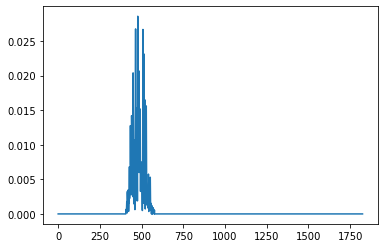

In [312]:
plt.plot(b1.calc_tof_traces()[1])


(100.0, 200.0)

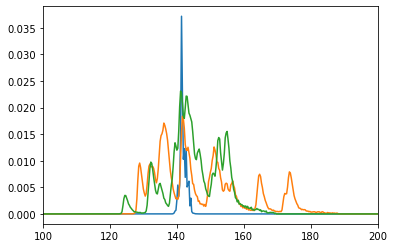

In [397]:
plt.plot(Raw_data.TOF_times,b1.get_all_tof()[0],Raw_data.TOF_times,b1.get_all_tof()[1],Raw_data.TOF_times,b1.get_all_tof()[2])
plt.xlim([100,200])
# plt.plot(1/1000*b1.get_raw_matrix()[1])

In [3]:
dt2 = np.dtype([('xuv', np.float64),('up', np.float64),('down', np.float64)])
measured_spectra=[]
for i in range(1,110):
    lll=np.fromfile('./resources/files_mathematica/'+str(i)+'.dat',dtype =dt2)
    xuv0=np.interp(tof_ens,orig_tof_ens,lll['xuv'],left=0,right=0)
    xuv0=xuv0/sum(xuv0)
    up0=np.interp(tof_ens,orig_tof_ens,lll['up'],left=0,right=0)
    up0=up0/sum(up0)
    down0=np.interp(tof_ens,orig_tof_ens,lll['down'],left=0,right=0)
    down0=down0/sum(down0)
    measured_spectra.append(np.array([xuv0,up0,down0]))
measured_spectra=np.asarray(measured_spectra)

In [4]:
from scipy.signal import gaussian
TOF_instrument_function=np.fromfile('./resources/files_mathematica/instrument_function.dat',dtype=np.float64)
gauss_spike=gaussian(11,0.05)[:10]

In [5]:
TOF_instrument_function-=TOF_instrument_function[0]
for num,i in enumerate(TOF_instrument_function):
    if i <0:
        TOF_instrument_function[num]=0
TOF_instrument_function=TOF_instrument_function[TOF_instrument_function>0]

In [6]:
class Pulse(object):


    fs_in_au=lambda t: 41.3414*t; # from fs to a.u.
    eV_in_au= lambda e: 0.271106*np.sqrt(e) # from eV to a.u.
    h=4.135667662 #in eV*fs
    
    class Data_Nonexisting_Error(Exception):
        def __init__(self, message):
            self.message = message
#     
    
    def __init__(self, EnAxis, EnOutput, TAxis, TOutput, num_electrons1, num_electrons2, dE = 0, dT = 0):
        from streaking_cal.statistics import weighted_avg_and_std
        
        if dE == 0:
            dE = weighted_avg_and_std(EnAxis.get(),cp.square(cp.abs(EnOutput)).get())[1]
            
        if dT == 0:
            dT = weighted_avg_and_std(TAxis.get(),cp.square(cp.abs(TOutput)).get())[1]
        
        
        self.dE = dE
        self.dT = dT
        self.__spec = EnOutput
        self.__eAxis = EnAxis
        self.__temp = TOutput
        self.__tAxis = TAxis
        self.num_electrons1=num_electrons1
        self.num_electrons2=num_electrons2
        self.__is_low_res = False
        self.__streakspeed=0
        del(EnAxis)
        del(EnOutput)
        del(TAxis)
        del(TOutput)
        
#     @property for read access only members
            
    
    @classmethod
    def from_GS(cls, dE = 0.35, dT = 35, centralE = 73, num_electrons1=25, num_electrons2=25):
        from streaking_cal.GetSASE import GetSASE_gpu as GS   
#         from streaking_cal.statistics import weighted_avg_and_std    


        (EnAxis, EnOutput, TAxis, TOutput)= GS(CentralEnergy=centralE, 
                             dE_FWHM=2.355*dE*2**0.5, 
                             dt_FWHM=2.355*dT*2**0.5,
                             onlyT=False)    
        EnAxis = EnAxis.astype("float32")
        TAxis = TAxis.astype("float32")
        EnOutput = EnOutput.astype("complex64")
        TOutput = TOutput.astype("complex64")

        
        return cls(EnAxis, EnOutput, TAxis, TOutput, num_electrons1, num_electrons2, dE, dT )
    
    @classmethod
    def from_file(cls, path_temp, num_electrons1 = 25, num_electrons2 = 25):
        TOutput=cp.fromfile(path_temp , dtype="complex64")
        TAxis = cp.fromfile("./GS_Pulses/axis/time_axis.dat" , dtype="float32")
        
        EnOutput=cp.fft.ifft(TOutput)
        EnAxis=cp.linspace(0,140,32*1024)
        
        return cls(EnAxis, EnOutput, TAxis, TOutput,num_electrons1, num_electrons2)

#     certain entries may be deleted after calculation of measured spectra
    def get_temp(self):
        return self.__temp
    
    def get_tAxis(self): 
        return self.__tAxis
    
    def get_spec(self):        
        if self.__is_low_res:
            return None
        else:
            return self.__spec
    
    def get_eAxis(self):
        if self.__is_low_res:
            return None
        else:
            return self.__eAxis
        
    def is_low_res(self):
        return self.__is_low_res
    
    def __get_streaked_spectra(self,streakspeed):
        if self.is_low_res ==True:
            return None
        else:
            from cupy.fft import fft
            
            fs_in_au=lambda t: 41.3414*t; # from fs to a.u.
            eV_in_au= lambda e: 0.271106*np.sqrt(e) # from eV to a.u.
        
            E0=232000*streakspeed # in V/m; shape of Vectorpotential determines: 232000 V/m = 1 meV/fs max streakspeed
            ff1=cp.flip(fft(self.__temp*cp.exp(-1j*fs_in_au(self.__tAxis)*(1/(2)*(p0*E0*p_times_A_vals_up + 
                                                                      1*E0**2*A_square_vals_up)))))
            ff2=cp.flip(fft(self.__temp*cp.exp(-1j*fs_in_au(self.__tAxis)*(1/(2)*(p0*E0*p_times_A_vals_down + 
                                                                      1*E0**2*A_square_vals_down)))))

            spectrum1=cp.square(cp.abs(ff1))
            spectrum2=cp.square(cp.abs(ff2))

    #         ff1=ff1/(cp.sum(cp.square(cp.abs(ff1))))
    #         ff1=ff2/(cp.sum(cp.square(cp.abs(ff2))))

            return spectrum1,spectrum2
    
    @staticmethod
    @vectorize([float64(float64,boolean)])
    def get_ind_vals(new_y, start):
        if not(start):
            new_y+=peak_max_y
        idx= np.abs(tof_ens - new_y).argmin()
        if start:
            if tof_ens[idx]<new_y:
                idx+=1
        else:
            if tof_ens[idx]>new_y+peak_max_y:
                idx-=1
        return idx
    
    @staticmethod
    def discretized_spectrum(spectrum,num_points):
        from numpy import interp
        spectrum = cp.asnumpy(spectrum)
        vals=Pulse.discrete_positions(spectrum,num_points)
        st=Pulse.get_ind_vals(vals,True).astype("int")
        en=Pulse.get_ind_vals(vals,False).astype("int")
        new_spec=np.zeros(len(tof_ens))
        
        orig_tof_no_off=orig_tof_ens[:10]-orig_tof_ens[0]
        for start,end,valq in zip(st,en,vals):
            intvals=tof_ens[start:end]
            new_int=np.interp(intvals,orig_tof_no_off+valq,Pulse.single_discrete_spike())
            new_spec[start:end]+=new_int
        new_spec=new_spec/sum(new_spec)
        return new_spec

    
#     def __discretized_spectrum(self,spectrum,num_points):
#         ll=len(self.__single_discrete_spike())
#         sval=self.__discrete_positions(spectrum,num_points)
#         sval_ens=interp(cp.array(sval),cp.arange(len(tof_ens)),tof_ens_gpu)
#         new_spec=cp.zeros(len(tof_ens))
#         one_spike_int = lambda r : interp(tof_ens_gpu
#                                           ,cp.asarray(orig_tof_ens[:ll]-orig_tof_ens[7])+r
#                                           ,self.__single_discrete_spike())
#         all_spikes=cp.array([one_spike_int(i) for i in sval_ens])
#         new_spec= cp.sum(all_spikes,axis=0)

#         return new_spec

    @staticmethod
    def single_discrete_spike():
        from numpy.random import rand
        from numpy import pad,floor,ceil
#         padval=(len(orig_tof_ens)-len(noisepeak))/2
        single_spike=0.4*rand(10)+gauss_spike
    #     single_spike= pad(single_spike, (floor(padval).astype(int), 
    #                                      ceil(padval).astype(int)), 'constant', constant_values=(0))
        return single_spike

    @staticmethod
    def discrete_positions(spectrum,num_points):
        from scipy.interpolate import interp1d
        from numpy import interp as npinterp
        from numpy.random import rand
        from numpy import cumsum
        from numpy import round as np_round
        spectrum=cp.asnumpy(spectrum)
        cumulative_spectrum=(np.cumsum(spectrum))/sum(spectrum)
        indices=np.arange(len(spectrum))
        discrete_positions=npinterp(rand(num_points),cumulative_spectrum,indices)
#         discrete_positions=mint(rand(num_points))
        discrete_positions=npinterp(discrete_positions,np.arange(len(tof_ens)),tof_ens)

    #     discrete_positions=np_round(discrete_positions)
        return discrete_positions
    
#     two methods (training and validation) from distinct original measurements to introduce 
#     background noise into the spectra
    def __makenoise_train(self,maxv):
        '''background noise used for training'''
        from numpy.random import randint
        from numpy import roll
        hnoise=measurednoise_train*cp.asnumpy(maxv)
        return roll(hnoise,np.random.randint(1,len(tof_ens)))[:len(tof_ens)]
    
    def __makenoise_val(self,maxv):
        '''background noise used for validation'''
        from numpy.random import randint
        from numpy import roll
        hnoise=measurednoise_val*cp.asnumpy(maxv)
        return roll(hnoise,np.random.randint(1,len(tof_ens)))[:len(tof_ens)]
    
    def get_spectra(self,streakspeed_in_meV_per_fs, keep_originals=False, discretized = True):
        '''returns streaked spectra, measured with "number_electronsx" simulated electrons or nondiscretized as a tuple'''
        from streaking_cal.statistics import weighted_avg_and_std
        
        if not(self.is_low_res()):
            
            (streaked1,streaked2)=self.__get_streaked_spectra(streakspeed_in_meV_per_fs)

            streaked1=interp(tof_ens_gpu,self.__eAxis,streaked1)
            streaked2=interp(tof_ens_gpu,self.__eAxis,streaked2) 
            xuvonly = interp(tof_ens_gpu,self.__eAxis,cp.square(cp.abs(self.__spec)))
            
            if not(keep_originals):        
                self.__eAxis = None
                self.__spec = None
                t_square=cp.square(cp.abs(self.__temp))
                t_mean,_ = weighted_avg_and_std(self.__tAxis.get(),t_square.get())
                self.__temp=interp(cp.asarray(standard_full_time),self.__tAxis-t_mean,t_square).get()    
                self.__temp=self.__temp/cp.sum(self.__temp)
                self.__tAxis=standard_full_time
                self.__is_low_res=True
                self.__streakedspectra= np.asarray((xuvonly.get(),streaked1.get(),streaked2.get()))
                self.__streakspeed=streakspeed_in_meV_per_fs
                self.__tAxis=standard_full_time;            
            
            if discretized:
                streaked1=self.discretized_spectrum(streaked1,self.num_electrons1)
                streaked2=self.discretized_spectrum(streaked2,self.num_electrons2)
                
            self.__streakspeed=streakspeed_in_meV_per_fs
            
            return cp.asnumpy(xuvonly),cp.asnumpy(streaked1),cp.asnumpy(streaked2)
        
        elif discretized:
            (xuvonly,streaked1,streaked2) =self.__streakedspectra 
            streaked1=self.discretized_spectrum(streaked1,self.num_electrons1)
            streaked2=self.discretized_spectrum(streaked2,self.num_electrons2)
           
            return cp.asnumpy(xuvonly),cp.asnumpy(streaked1),cp.asnumpy(streaked2)
            
            
        else:    
            return self.__streakedspectra.copy()
         
        
    def get_augmented_spectra(self,streakspeed_in_meV_per_fs,for_training=False, discretized = True):
        '''data augemtation to imitate: shift of XUV-energy, jitter between Streaking and XUV, background signal
        values here are handcrafted for the (reduced) chosen resolution of self.__eAxis and might 
        need be adjusted in the future
        ;Returns augemented spectra as a matrix'''
        from numpy.random import randint
        from numpy import asarray, roll
        from sklearn.preprocessing import Normalizer
                
        aug_spectra = np.asarray(self.get_spectra(streakspeed_in_meV_per_fs, discretized= discretized))
        
#         to reduce dependancy from XUV-photon energy
        shiftall= randint(-60,60)
#         to account for jitter
        shiftstr = randint(0,40)
        
        aug_spectra[0]= roll(aug_spectra[0],shiftall)
        aug_spectra[1]= roll(aug_spectra[1],shiftall-shiftstr)          
        aug_spectra[2]= roll(aug_spectra[2],shiftall+shiftstr)
        
#         add background signal from actual measurements
#         if for_training:
#             aug_spectra[1]=aug_spectra[1]+self.__makenoise_train(max(aug_spectra[1]))
#             aug_spectra[2]=aug_spectra[2]+self.__makenoise_train(max(aug_spectra[2]))
            
#         else:
#             aug_spectra[1]=aug_spectra[1]+self.__makenoise_val(max(aug_spectra[1]))
#             aug_spectra[2]=aug_spectra[2]+self.__makenoise_val(max(aug_spectra[2])) 
            
         
#         aug_spectra[1]=np.convolve(noisepeak,aug_spectra[1],mode="same")
#         aug_spectra[2]=np.convolve(noisepeak,aug_spectra[2],mode="same")
        
#             normalize to area 1
        hnormalizer = Normalizer(norm ="l1")
        norm1 = hnormalizer.transform(aug_spectra)
                                      
        return norm1
        
    def to_file(self, writepath):
        if self.is_low_res():
            raise self.Data_Nonexisting_Error('High resolution data is already deleted. Use to_file() before calculating streaked spectra or with get_spectra(keep_originals = True) ') 
        else:
            self.get_temp().get().tofile(writepath)
        
    def get_streakspeed(self):
        return self.__streakspeed       
    
    def to_raw_data(self):
        pass
        
    
    
        

## Save 10000 pulses for reference and validation

In [6]:
# pbar = ProgressBar()
# for i in pbar(range(10000)):
#     a = Pulse.from_GS(dE = 0.4, dT = 45, num_electrons1=200, num_electrons2=200)
#     a.to_file("./Pulses/GetSASE/Pulse_"+str(i)+".dat")

In [7]:
# %%timeit
pbar = ProgressBar()

num_pulses=1300
streakspeed = 95 # meV/fs
X= [""]*num_pulses
y= [""]*num_pulses

for i in pbar(range(num_pulses)):
    x1 = Pulse.from_GS(dT = np.random.uniform(10/2.355,120/2.355)
                  , dE = np.random.uniform(0.2/2.355,1.8/2.355)
                  , num_electrons1=np.random.randint(20,31)
                  , num_electrons2=np.random.randint(20,31)
                 )
    x1.get_spectra(streakspeed,discretized=False)
    X[i] = x1
    
    

100% (1300 of 1300) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


In [54]:
for i in X:
    i.num_electrons1=np.random.randint(520,531)
    i.num_electrons2=np.random.randint(520,531)

In [8]:

class Datagenerator(Sequence):
    def __init__(self, x_set,y_set, batch_size, for_train =True):
        self.x, self.y = x_set, y_set
#         self.pulses = pulses
        self.batch_size = batch_size
#         self.xdims = xdims
#         self.ydims = ydims
#         self.time=time
        self.for_train=for_train

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        from tensorflow.keras.utils import Sequence
        from scipy.ndimage import gaussian_filter
        from numpy.random import uniform, randint
        import numpy as np 
        from numpy import zeros
        
        batch = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

#         x = [X[i].get_raw_matrix() for i in batch]

        x=[]
        for ind,i in enumerate(batch):
            (xuv,str1,str2)=X[i].get_augmented_spectra(streakspeed,discretized=False)
            b1=Raw_data(np.asarray((xuv,str1,str2)),tof_ens,X[i].get_temp(),num_electrons1=X[i].num_electrons1,num_electrons2=X[i].num_electrons2)
            x.append(b1.get_raw_matrix())
#             x[ind]=b1.get_all_tof()
#             y.append(b1.get_temp())


#         x = [X[i].get_augmented_spectra(0,discretized=False) for i in batch]
        x = np.asarray(x)
               
        y = [X[i].get_temp() for i in batch]
        y = np.asarray(y)
        

        return x.reshape(-1,3, x[0].shape[1],1), np.array(y) #.reshape(self.batch_size, -1)
    
    

In [9]:
class CenterAround(tf.keras.constraints.Constraint):
#   """Constrains weight tensors to be centered around `ref_value`."""

    def __init__(self, ref_value):
        self.ref_value = ref_value

    def __call__(self, w):
        mean = tf.reduce_mean(w)
        return w - mean + self.ref_value
    def get_config(self):
        return {'ref_value': self.ref_value}

In [10]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Subtract, GlobalMaxPooling2D, Conv2D, Dense, Lambda
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, BatchNormalization


convdim=128

inputs= Input(shape=(3, 1825,1), name="traces")

# x = BatchNormalization()(inputs)




conv_out = Conv2D(convdim, kernel_size=(3,500), activation="relu", input_shape=(3, 1825,1)
           ,strides=1,padding="same"
          )(inputs)


# x = MaxPooling2D(pool_size=(3, 3),strides=(1,2), padding="valid")(conv_out)
# x2 = AveragePooling2D(pool_size=(3, 3),strides=(1,2), padding="valid")(conv_out)

# x = Subtract()([x, x2])

x= GlobalMaxPooling2D()(conv_out)

# x = tf.keras.layers.LeakyReLU()(x)

x = BatchNormalization()(x)

x= Dense(256,activation="relu"
#          , kernel_constraint=CenterAround(0)
        )(x)

# x= Dense(10,activation="relu"
# #          , kernel_constraint=CenterAround(0)
#         )(x)

# x= Dense(100,activation="relu"
# #          , kernel_constraint=CenterAround(0)
#         )(x)


outputs = Dense(standard_full_time.shape[0], activation="softmax")(x)

model = tf.keras.Model(inputs, outputs, name="mynet")
model.summary()

Model: "mynet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
traces (InputLayer)          [(None, 3, 1825, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 1825, 128)      192128    
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
Total params: 357,248
Trainable params: 356,992
Non-trainable params: 256
_____________________________________________________

In [11]:
from sklearn.model_selection import train_test_split

wholeset =np.arange(len(X));

pulses_train, pulses_test, y_train, y_test = train_test_split(wholeset,wholeset,test_size =0.05 ,random_state =1)
params = {'batch_size': 250}
train_ds = Datagenerator(pulses_train,y_train,**params)
test_ds = Datagenerator(pulses_test,y_test,for_train =False,**params)

# time2=time[abs(time)<250]
          


In [216]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=1e-3, decay=1e-3 / 200) #200 war hier mal number_of_epochs

In [12]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay( initial_learning_rate= 0.2, decay_steps=15000, decay_rate= 0.99
                                              ,staircase= True)
nadam =   tf.keras.optimizers.Nadam(learning_rate=0.01)
adagrad =    tf.keras.optimizers.Adagrad(learning_rate=lr_schedule, initial_accumulator_value=0.1)
model.compile(optimizer="nadam",loss="KLDivergence", metrics=["accuracy","mae"])

history= model.fit(x=train_ds,validation_data=test_ds,
#                     use_multiprocessing=True,
#                     workers=4,
                    epochs=25
                   )

Epoch 1/25
5/5 [==============================] - 4s 896ms/step - loss: 2.0110 - accuracy: 0.0219 - mae: 0.0030 - val_loss: 2.2331 - val_accuracy: 0.0308 - val_mae: 0.0032
Epoch 2/25
5/5 [==============================] - 3s 640ms/step - loss: 1.8036 - accuracy: 0.0308 - mae: 0.0029 - val_loss: 2.1534 - val_accuracy: 0.0154 - val_mae: 0.0031
Epoch 3/25
5/5 [==============================] - 3s 642ms/step - loss: 1.2043 - accuracy: 0.0372 - mae: 0.0024 - val_loss: 1.9935 - val_accuracy: 0.0154 - val_mae: 0.0031
Epoch 4/25
5/5 [==============================] - 3s 643ms/step - loss: 0.6994 - accuracy: 0.0445 - mae: 0.0018 - val_loss: 1.8427 - val_accuracy: 0.0154 - val_mae: 0.0030
Epoch 5/25
5/5 [==============================] - 3s 637ms/step - loss: 0.5314 - accuracy: 0.0316 - mae: 0.0016 - val_loss: 1.7239 - val_accuracy: 0.0308 - val_mae: 0.0029
Epoch 6/25
5/5 [==============================] - 3s 644ms/step - loss: 0.4722 - accuracy: 0.0316 - mae: 0.0015 - val_loss: 1.6516 - val_acc

KeyboardInterrupt: 

In [ ]:
#"nadam"
#701 points, 5 epochs, 130000 pulses,val_loss=0.3551
#1401 points, 5 epochs, 130000 pulses,val_loss=0.3532
#model-split:1401 points 25 epochs, 130000 pulses val_loss= 0.3572 (0.3555-0.3572)
#model-normal:1401 points 25 epochs, 130000 pulses val_loss= 0.3562 (0.3554-0.3562)
#model-normal, all TOF:1401 points, 25 els, 25 epochs, 130000 pulses val_loss= 0.3565 (0.3565-0.3576)
#model-normal, all TOF:1401 points, 500 els, 25 epochs, 130000 pulses val_loss= 0.2935 (0.2930-0.2950)?
#model-normal:1401 points, 500 els, 25 epochs, 130000 pulses val_loss= 0.3019 (0.2921-0.3019)
#adam 1e-3
#model-normal:1401 points 25 epochs, 130000 pulses val_loss= 0.3550 (0.3550-0.3568)

In [ ]:

%matplotlib inline
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [74]:
with open('./GS-95_20-31els-conv/trainHistoryDict.dat', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
%matplotlib inline
plt.plot(history["loss"])
plt.plot(history["val_loss"])

In [78]:
import pickle
history = pickle.load(open("./GS-95_20-31els-conv/trainHistoryDict.dat", "rb"))

In [ ]:
mempool.free_all_blocks()
print(mempool.used_bytes())
print(mempool.total_bytes()) 

In [42]:
# model.save('./GS-95_20-31els-conv')
# 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./GS-95_20-31els-conv\assets


In [6]:
model = tf.keras.models.load_model('./GS-95_20-31els-conv')

In [126]:
msle = tf.keras.losses.MeanAbsoluteError()

In [406]:
# model.evaluate(X_test.reshape(-1, 3, xdims, 1), y_test)


In [36]:
# preds=model.predict(np.asarray(X_test).reshape(-1, 3, xdims, 1))

(400.0, 650.0)

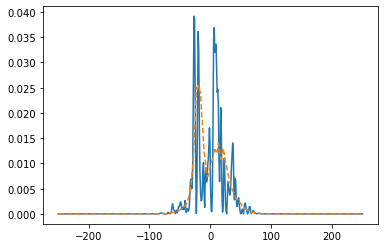

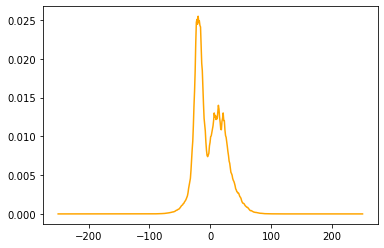

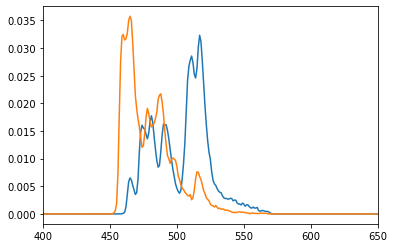

In [53]:
testitems= test_ds.__getitem__(1)
preds=model.predict(testitems[0])
y_test=testitems[1]
%matplotlib inline
vv=108


plt.plot(standard_full_time,y_test[vv])
plt.plot(standard_full_time,preds[vv],'--')
# plt.plot(time,gaussian_filter(y_test[vv],10))

plt.figure()
plt.plot(standard_full_time,preds[vv],'orange')

plt.figure()
# plt.plot(tof_ens,testitems[0][vv][0])
plt.plot(np.arange(1825),testitems[0][vv][1])
plt.plot(np.arange(1825),testitems[0][vv][2])
# plt.plot(np.arange(1825),testitems[0][vv][0])
plt.xlim([400,650])


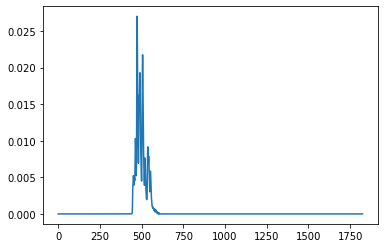

In [44]:
plt.plot(test_ds.__getitem__(0)[0][5][1])

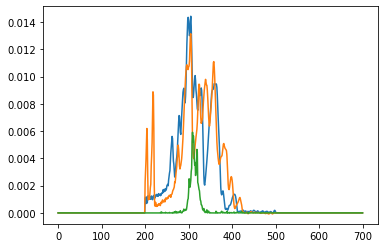

In [55]:
nnn=99

plt.plot(measured_spectra.reshape(-1,3,701,1)[nnn][1])
plt.plot(measured_spectra.reshape(-1,3,701,1)[nnn][2])
plt.plot(0.1*measured_spectra.reshape(-1,3,701,1)[nnn][0])

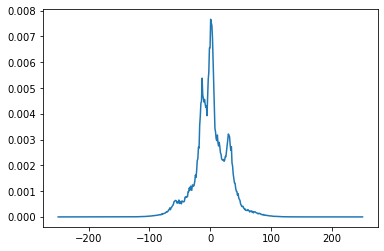

In [48]:
plt.plot(standard_full_time,np.min(preds,axis=0))

In [7]:
measured_spectra2=measured_spectra.reshape(-1,3,701,1)
preds=model.predict(measured_spectra2)

(-200.0, 200.0)

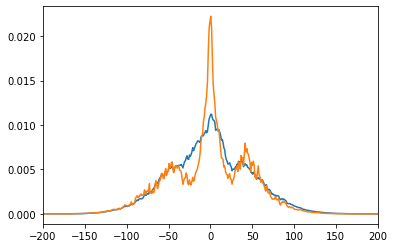

In [10]:
plt.plot(standard_full_time,preds[86])
plt.plot(standard_full_time,preds[105])
plt.xlim([-200,200])

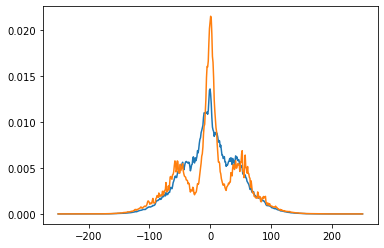

In [11]:
plt.plot(standard_full_time,preds[99])
plt.plot(standard_full_time,preds[13])

In [12]:
fwhm=[]
for i in preds:
    meanval,stdval = weighted_avg_and_std(standard_full_time,i)
    fwhm.append(stdval*2.35)
np.mean(fwhm)

105.9938095791034

6.734564184595566

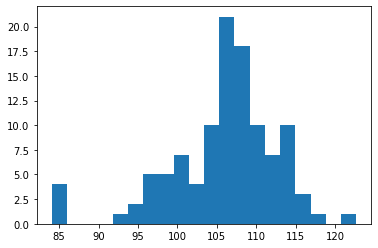

In [13]:
plt.hist(fwhm,20)
np.std(fwhm)

In [14]:
kl = tf.keras.losses.KLDivergence(
    reduction=tf.keras.losses.Reduction.SUM)
kl = tf.keras.losses.MeanSquaredLogarithmicError(
    reduction=tf.keras.losses.Reduction.SUM)

In [15]:
def next_indexf(current_trace,left_traces,left_indices):
    lowest_dist=100
    nearest_pos=0
    for num, itrace in enumerate(left_traces):
        temp_dist = kl(current_trace, itrace).numpy()
        if temp_dist<lowest_dist:
            lowest_dist=temp_dist
            nearest_pos=num
    return left_indices[nearest_pos]
            
        

In [16]:
left_traces=preds
left_indices=np.arange(len(preds))
sorted_indices=[]
start_index=13
next_index=start_index

sorted_indices.append(next_index)

left_traces=np.delete(left_traces,next_index,axis=0)
left_indices=np.delete(left_indices,np.argwhere(left_indices==next_index))

while len(left_traces)>0:
#     print(ne)

    next_index = next_indexf(preds[start_index],left_traces,left_indices)
    sorted_indices.append(next_index)
#     print(left_indices)
#     print(len(left_traces))
    left_traces=np.delete(left_traces,np.argwhere(left_indices==next_index),axis=0)
    left_indices=np.delete(left_indices,np.argwhere(left_indices==next_index))
    

sorted_indices= np.asarray(sorted_indices)

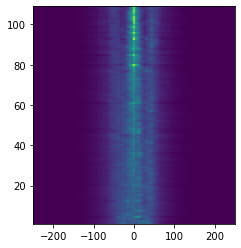

In [23]:
plt.imshow(preds[sorted_indices], extent=[-250,250,1,109],aspect = 5)

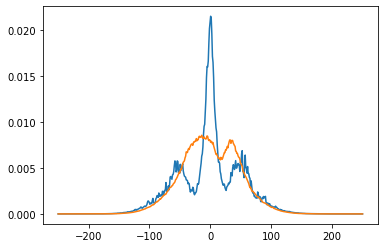

In [33]:
plt.plot(standard_full_time,preds[sorted_indices[0]])
plt.plot(standard_full_time,preds[sorted_indices[106]])

In [24]:
def fwhm(trace,time):
    half_max=0.5*max(trace)
    all_pos=np.where(preds[1]>half_max)
    return time[max(all_pos[0])]-time[min(all_pos[0])]

In [25]:
fwhm_vals = [fwhm(i,standard_full_time) for i in preds]
fwhm_vals = np.asarray(fwhm_vals)


In [36]:
preds[45<fwhm_vals]

array([[5.6096127e-08, 5.4795986e-08, 8.3345547e-08, ..., 6.3304384e-08,
        9.3449479e-08, 8.1092338e-08],
       [3.3974715e-08, 2.9314023e-08, 4.0802597e-08, ..., 3.3231398e-08,
        4.4868184e-08, 3.7321715e-08],
       [8.5425967e-08, 8.4533525e-08, 1.4211378e-07, ..., 9.9211022e-08,
        1.4376950e-07, 1.2263199e-07],
       ...,
       [3.9528210e-08, 3.7523229e-08, 5.5465577e-08, ..., 4.1302055e-08,
        5.9274452e-08, 5.2119997e-08],
       [8.1877793e-08, 7.6434596e-08, 1.0901626e-07, ..., 8.4851926e-08,
        1.2232948e-07, 1.0375831e-07],
       [1.3913194e-08, 1.2215863e-08, 1.8895181e-08, ..., 1.5538854e-08,
        2.0014660e-08, 1.6255424e-08]], dtype=float32)

(array([14., 19., 47., 15.,  0.,  0.,  0.,  6.,  5.,  3.]),
 array([21.52641879, 26.81017613, 32.09393346, 37.3776908 , 42.66144814,
        47.94520548, 53.22896282, 58.51272016, 63.7964775 , 69.08023483,
        74.36399217]),
 <BarContainer object of 10 artists>)

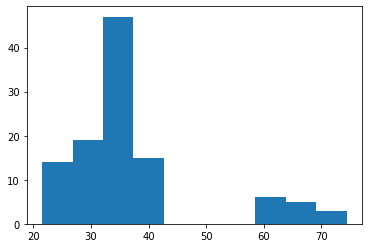

In [26]:
plt.hist(fwhm_vals)

In [40]:
%matplotlib widget
plt.plot(standard_full_time,preds[45<fwhm_vals][3])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [41]:
np.where(preds[1]>0.5*0.026174543)[0]

array([245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
       258, 259, 260, 261, 262, 263, 264, 265, 266, 267], dtype=int64)